In [1]:
#######################################################################
# Helpful links on similar projects:
#######################################################################

# 3x3 FIBA rules https://fiba3x3.com/en/rules.html
# Elam ending - https://www.inpredictable.com/2021/03/an-elam-ending-win-probability.html
# NBA win prob - https://www.inpredictable.com/2015/02/updated-nba-win-probability-calculator.html
# Four factors - https://www.inpredictable.com/2016/04/new-box-score-feature-pace-and.html
# Pace/Eff - https://www.inpredictable.com/2016/04/new-box-score-feature-pace-and.html
# ELAM sims - https://gist.github.com/boooeee/6cddc011feb45cf47aa4c37d706a3cef

import pandas as pd
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import scipy.special as sps  

import multiprocessing

pd.set_option('display.max_columns', None)

# Key

In [2]:
key = pd.read_csv("data/README.csv")
key.set_index('field')

desc\t\t\t
field                                             
id                   game id (pdf gamebook name)\t
m                            game clock (minute)\t
s                            game clock (second)\t
p1                     play description (team 1)\t
s1                                  team 1 score\t
s2                                  team 2 score\t
p2                     play description (team 2)\t
ot                       is the game in overtime\t
pid                                      play id\t
gt                seconds elapsed (in game time)\t
fp1             did team 1 get first possession?\t
fp2          did team 2 get first possession?B13\t
md1pt1      1 point shot made indicator (team 1)\t
ms1pt1      1 point shot miss indicator (team 1)\t
md2pt1      2 point shot made indicator (team 1)\t
ms2pt1      2 point shot miss indicator (team 1)\t
dr1          defensive rebound indcator (team 1)\t
or1          offensive rebound indcator (team 1)\t
md1                 made shot indicator (team 1)\t
to1                  turnover indicator (team 1)\t
ft1                free throw indicator (team 1)\t
md1pt2      1 point shot made indicator (team 2)\t
ms1pt2      1 point shot miss indicator (team 2)\t
md2pt2      2 point shot made indicator (team 2)\t
ms2pt2      2 point shot miss indicator (team 2)\t
dr2          defensive rebound indcator (team 2)\t
or2          offensive rebound indcator (team 2)\t
md2                 made shot indicator (team 2)\t
to2                  turnover indicator (team 2)\t
ft2                free throw indicator (team 2)\t
pos1    beginning of possession indicator (team 1)
pos2    beginning of possession indicator (team 2)
mgn                                         points

# Data Exploration

In [3]:
###############################
# General data dimensions
###############################

pbp = pd.read_csv("data/mens_3x3_pbp.csv")

# Add possession columns to easily tell which team has ball
pbp['t1pos'] = pbp['p1'].isna()
pbp['t2pos'] = pbp['p2'].isna()

# Add column to determine amount of time burned in last possession
pbp['last_poss_gt'] = pbp['gt'].shift(1)
pbp['last_poss_gt'] = pbp['gt'] - pbp['last_poss_gt']

first_game = pbp.id.unique()[0]
first_game

total_games = len(pbp['id'].unique())
total_plays = len(pbp['pid'])
nrows = pbp.shape[0]

print("There are {} unique games".format(total_games))
print("\nThere are {} individual plays".format(total_plays))

There are 34 unique games

There are 5051 individual plays


In [4]:
###############################
# Time of possession stats
###############################

temp = pbp[pbp['last_poss_gt'] > 0]
min_time_elapsed = temp['last_poss_gt'].min()
max_time_elapsed = temp['last_poss_gt'].max()

print("The min time elapsed for one possession is {}".format(min_time_elapsed))
print("The max time elapsed for one possession is {}".format(max_time_elapsed))

plot = temp['last_poss_gt'].plot.hist(xlabel='Time of Poss', ylabel='Freq', title='True time of possession counts',colormap='summer',bins=20)

fig = plot.get_figure()
fig.savefig("output/true_top_counts_v1.png")

The min time elapsed for one possession is 1.0
The max time elapsed for one possession is 26.0


In [5]:
shape, scale = 11.5, .65 # mean=4, std=2*sqrt(2)

count, bins, ignored = plt.hist(temp['last_poss_gt'], 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  

plt.savefig('output/true_top_v2.png')

plt.show()

In [6]:
#################################################################################
# ORED/DREB %
#################################################################################

#Offensive rebound %

t1_m1 = pbp[pbp['ms1pt1'] == True].shape[0]
t1_m2 = pbp[pbp['ms1pt2'] == True].shape[0]
t1_tot_miss = t1_m1 + t1_m2

t2_m1 = pbp[pbp['ms2pt1'] == True].shape[0]
t2_m2 = pbp[pbp['ms2pt2'] == True].shape[0]
t2_tot_miss = t2_m1 + t2_m2


print("Total missed shots (Team 1): {}".format(t1_tot_miss))
print("Total missed shots (Team 2): {}".format(t2_tot_miss))

t1_orb = pbp[pbp['or1'] == True].shape[0]
t2_orb = pbp[pbp['or2'] == True].shape[0]

print("\nTotal missed shots (Team 1): {}".format(t1_orb))
print("Total missed shots (Team 2): {}".format(t2_orb))

print("\nORB % (Team 1): {}".format(t1_orb/t1_tot_miss))
print("ORB % (Team 2): {}".format(t2_orb/t2_tot_miss))

total_orb = t1_orb + t2_orb
total_miss = t1_tot_miss + t2_tot_miss


print("\nTotal rebound % (Team 1 + Team 2): {}".format(total_orb/total_miss))

Total missed shots (Team 1): 412
Total missed shots (Team 2): 564

Total missed shots (Team 1): 171
Total missed shots (Team 2): 178

ORB % (Team 1): 0.41504854368932037
ORB % (Team 2): 0.31560283687943264

Total rebound % (Team 1 + Team 2): 0.35758196721311475


In [7]:
# Defensive rebound %

t1_m1 = pbp[pbp['ms1pt1'] == True].shape[0]
t1_m2 = pbp[pbp['ms1pt2'] == True].shape[0]
t1_tot_miss = t1_m1 + t1_m2

t2_m1 = pbp[pbp['ms2pt1'] == True].shape[0]
t2_m2 = pbp[pbp['ms2pt2'] == True].shape[0]
t2_tot_miss = t2_m1 + t2_m2


print("Total missed shots (Team 1): {}".format(t1_tot_miss))
print("Total missed shots (Team 2): {}".format(t2_tot_miss))

t1_drb = pbp[pbp['dr1'] == True].shape[0]
t2_drb = pbp[pbp['dr2'] == True].shape[0]

print("\nTotal ORB shots (Team 1): {}".format(t1_orb))
print("Total ORB shots (Team 2): {}".format(t2_orb))

print("\nDRB % (Team 1): {}".format(t1_orb/t1_tot_miss))
print("DRB % (Team 2): {}".format(t2_orb/t2_tot_miss))

total_drb = t1_drb + t2_drb
total_miss = t1_tot_miss + t2_tot_miss


print("\nTotal rebound % (Team 1 + Team 2): {}".format(total_drb/total_miss))

# Sanity check
sanity_check = total_drb/total_miss + total_orb/total_miss

print("\nSanity check: {}".format(sanity_check))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'ORB', 'DRB'
sizes = [total_orb,total_drb]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('output/true_orb_drb_per.png')

plt.show()

Total missed shots (Team 1): 412
Total missed shots (Team 2): 564

Total ORB shots (Team 1): 171
Total ORB shots (Team 2): 178

DRB % (Team 1): 0.41504854368932037
DRB % (Team 2): 0.31560283687943264

Total rebound % (Team 1 + Team 2): 0.6434426229508197

Sanity check: 1.0010245901639343


Total shots taken (team 1 + team 2) regardless of miss or make:
1815
% total shots that are 1pt shots:
   0.5619834710743802
% shots that are 2pt shots:
   0.4380165289256198


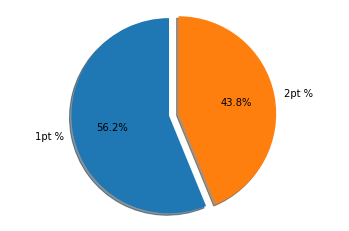

In [8]:
#################################################################################
# 1 pt vs 2pt shot percentages
#################################################################################

t1_1pt_shots = pbp[(pbp['md1pt1'] == True) | (pbp['ms1pt1'] ==True)].shape[0]
t1_2pt_shots = pbp[(pbp['md2pt1'] == True) | (pbp['ms2pt1'] ==True)].shape[0]

t2_1pt_shots = pbp[(pbp['md1pt2'] == True) | (pbp['ms1pt2'] ==True)].shape[0]
t2_2pt_shots = pbp[(pbp['md2pt2'] == True) | (pbp['ms2pt2'] ==True)].shape[0]

total_1pt = t1_1pt_shots + t2_1pt_shots
total_2pt = t1_2pt_shots + t2_2pt_shots

total_shots = t1_1pt_shots + t1_2pt_shots + t2_1pt_shots + t2_2pt_shots

print("Total shots taken (team 1 + team 2) regardless of miss or make:\n{}".format(total_shots))

print("% total shots that are 1pt shots:\n   {}".format(total_1pt/total_shots))
print("% shots that are 2pt shots:\n   {}".format(total_2pt/total_shots))

labels = '1pt %', '2pt %'
sizes = [total_1pt,total_2pt]
explode = (0.1, 0.0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('output/true_1pt_2pt_shot_per.png')

plt.show()

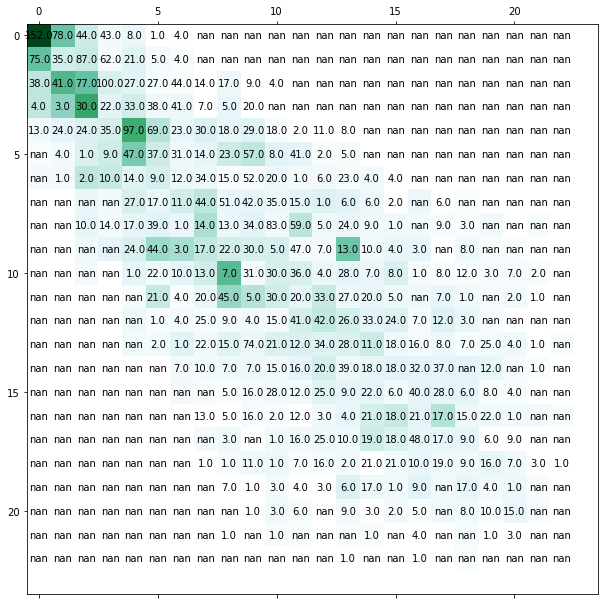

In [9]:
######################################################
# num of possessions played at each score
# Get idea of the sample size for each situation
######################################################

#poss_count = pd.DataFrame(np.zeros((24, 24)))
poss_count = pd.DataFrame(index=range(0,24),columns=range(0,24), dtype='int')

indices = pbp.index.values

for idx in indices:
    temp = pbp.loc[idx]
    temp = temp.fillna(0)
    score1 = int(temp['s1'])
    score2 = int(temp['s2'])
    if pd.isna(poss_count.loc[score1,score2]):
        poss_count.loc[score1,score2] = 1
    else:
        poss_count.loc[score1,score2] = poss_count.loc[score1,score2] + 1
    
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.matshow(poss_count, cmap=plt.cm.BuGn)

for i in range(23):
    for j in range(23):
        c = poss_count[j][i]
        ax.text(i, j, str(c), va='center', ha='center')
        
fig.savefig('output/true_per_score_pos.png')

In [10]:
##################################################
# True win % for all the possessions
##################################################

pbp['t1_win'] = np.nan
pbp['t2_win'] = np.nan

def add_winner_col(grp):
    s1 = grp["s1"].iloc[-1]
    s2 = grp["s2"].iloc[-1]
    
    if s1 > s2:
        grp['t1_win'] = True
        grp['t2_win'] = False
    elif s2 > s1:
        grp['t1_win'] = False
        grp['t2_win'] = True
    
    return grp

def cal_win_per(grp):
    temp1 = grp[grp['t1_win'] == 1.0]
    temp2 = grp[grp['t2_win'] == 1.0]
    
    t1_wins = None
    t2_wins = None
    
    if temp1.empty:
        t1_wins = 0
    else:
        t1_wins = len(temp1)
        
    if temp2.empty:
        t2_wins = 0
    else:
        t2_wins = len(temp2)
        
    if t1_wins == 0:
        return 0.0
    
    win_per = t1_wins/(t1_wins+t2_wins)
        
    return win_per

pbp = pbp.groupby('id').apply(add_winner_col)

##################################
# Building a true win % matrix 
##################################

temp = pbp.dropna(subset=['t1_win', 't2_win'])

scores = temp.groupby(['s1','s2'])

#true_win_counts = pd.DataFrame(np.zeros((24, 24)))
true_win_counts = pd.DataFrame(index=range(0,24),columns=range(0,24), dtype='float')

for name,score in scores:
#     print("t1 {} t2 {}".format(name[0],name[1]))
#     print(win_per)

    win_per = cal_win_per(score)
    win_per = round(win_per,2)
    
    idx1 = int(name[0])
    idx2 = int(name[1])
    
    true_win_counts.loc[idx1,idx2] = win_per
    
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.matshow(true_win_counts, cmap=plt.cm.summer)

for i in range(23):
    for j in range(23):
        c = true_win_counts[i][j]
        ax.text(i, j, str(c), va='center', ha='center')
        
plt.savefig('output/true_win_per.png')

# Simulating game statistics

In [11]:
###############################################
# Simulating possession lengths and scores to
# see how our distributions line up with existing data
###############################################

# Given an array of score probs for 0-3 points, returns a score
def score_decision(score_probs):
    prob_0 = score_probs[0]
    prob_1 = score_probs[0] + score_probs[1]
    prob_2 = score_probs[0] + score_probs[1] + score_probs[2]
    prob_3 = score_probs[0] + score_probs[1] + score_probs[2] + score_probs[3]

    rand = random.random()

    if rand <= prob_0:
        return 0
    if rand > prob_0 and rand <= prob_1:
        return 1
    if rand > prob_1 and rand <= prob_2:
        return 2
    if rand > prob_2 and rand <= prob_3:
        return 3

    print(rand)
    print("ERROR")

    return -1

#point probabilities for each possession : 0-1-2-3 points #
pp=[0.536,0.325,0.137,0.002]

temp = []
for x in range(10000):
    temp.append(score_decision(pp))

temp = pd.Series(temp)

plot = temp.value_counts().sort_values().plot(kind = 'barh',xlabel='Score', ylabel='Freq', title='Simulated Scores (N=10000)')
fig = plot.get_figure()
fig.savefig('output/sim_poss_length.png')

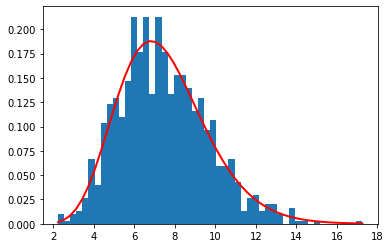

In [12]:
####################################
# Simulating possession length
####################################

#shape, scale = 11.5, .75 # mean=4, std=2*sqrt(2)
shape, scale = 11.5, .65 # mean=4, std=2*sqrt(2)

s = np.random.gamma(shape, scale, 1000)

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  

plt.savefig('output/sim_poss_len.png')

plt.show()

# Model

In [13]:
################################################################################
# Game state represented by 3 things: 
# Distance to target: How far away the leading team's score is from score that determines the end of the game
# Leading Team Scoring Margin: How many points the leading team is ahead by
# Possession: Whether the leading team has possession or not
# Time remaining: the time left in the game until it is over (in seconds)
################################################################################

class game_state(object):
    def __init__(self, score1,score2,possession,time_elapsed):
        self.t1_score = score1
        self.t2_score = score2
        self.possession = possession
        self.current_time = time_elapsed
        
    def get_t1_score(self):
        return self.t1_score
    
    def get_t2_score(self):
        return self.t2_score
    
    def get_possession(self):
        return self.possession
    
    def get_current_time(self):
        return self.current_time
    
    def set_t1_score(self,val):
        self.t1_score = val
        
    def set_t2_score(self,val):
        self.t2_score = val
    
    def set_possession(self,vals):
        self.possession = vals
    
    def set_current_time(self,val):
        self.current_time = val
        
    # A simple method to return true/false based on a given probability
    def decision(self,probability):
        rand = random.random()
        return rand<probability

    # Given an array of score probs for 0-3 points, returns a score
    def score_decision(self,score_probs):
        prob_0 = score_probs[0]
        prob_1 = score_probs[0] + score_probs[1]
        prob_2 = score_probs[0] + score_probs[1] + score_probs[2]
        prob_3 = score_probs[0] + score_probs[1] + score_probs[2] + score_probs[3]

        rand = random.random()

        if rand <= prob_0:
            return 0
        if rand > prob_0 and rand <= prob_1:
            return 1
        if rand > prob_1 and rand <= prob_2:
            return 2
        if rand > prob_2 and rand <= prob_3:
            return 3

        print(rand)
        print("ERROR")
        
        return -1

    # Returns one possession's simualted length in seconds
    def sim_poss_len(self,game_clock):
        shape, scale = 11.5, .65 # mean=4, std=2*sqrt(2)
        s = np.random.gamma(shape, scale, 1)
        
        time_elapsed = s[0]
        
        return time_elapsed

    def sim_next_play(self,overtime=False):
        
        # Current possession status
        curr_poss = self.get_possession()
        
        # get team scores
        t1_score = self.get_t1_score()
        t2_score = self.get_t2_score()
        
        # Current game clock
        game_clock = self.get_current_time()
        
        # point probabilities for each possession : 0-1-2-3 points #
        pp=[0.536,0.325,0.137,0.002]
        
        # If there is less than 1.5 secs on the clock we make it harder to score
        if overtime == False:
            if (600-game_clock) < 1.5:
                pp=[0.798,0.15,0.05,0.002]
        
        # Sim the time elapsed in the possession
        time_elapsed = self.sim_poss_len(game_clock)
        
        # If the game is almost over and the team leading has the ball, increase ToP by a factor of 1.2
        if overtime == False:
            if (600-game_clock) < 90.0:
                if curr_poss[0] == True:
                    if t1_score > t2_score:
                        time_elapsed = time_elapsed * 1.2
                elif curr_poss[1] == True:
                    if t2_score > t1_score:
                        time_elapsed = time_elapsed * 1.2
        
        # If the time elapsed is > available time we adjust
        if overtime == False:
            if (game_clock + time_elapsed) > 600:
                diff = (game_clock + time_elapsed) - 600
                time_elapsed = time_elapsed - diff
        
        # Simulate the score change for the play
        score_change = self.score_decision(pp)
        
        if curr_poss[0] == True:
            self.set_t1_score(t1_score + score_change)
        elif curr_poss[1] == True:
            self.set_t2_score(t2_score + score_change)
        else:
            raise ValueError('A very specific bad thing happened')
        
        self.set_current_time(game_clock + time_elapsed)
        
        if score_change != 0:
            off_rebound = self.decision(.30)
        else:
            off_rebound = False
        
        if off_rebound != True:
            self.set_possession([not elem for elem in self.possession]) 

    def sim_game(self,verbose=False):
        
        game_over = False
        
        ot = False
        
        target_score = 21
        
        while game_over != True:

            t1_score = self.get_t1_score()
            t2_score = self.get_t2_score()
            
            game_clock = self.get_current_time()
            
            if t1_score >= target_score:
                if verbose==True:
                    if ot == True:
                        print("T1 WINS :) (OT by score of {} to {})".format(t1_score,t2_score))
                    else:
                        print("T1 WINS :) (Reg time win score of {} to {})".format(t1_score,t2_score))
                return 1
            if t2_score >= target_score:
                if verbose == True:
                    if ot==True:
                        print("T2 WINS :/ (OT by score of {} to {})".format(t1_score,t2_score))
                    else:
                        print("T2 WINS :/ (Reg time win score of {} to {})".format(t1_score,t2_score))
                return 2
                        
            if game_clock == 600:
                if t1_score > t2_score:
                    if verbose == True:
                        print("T1 WINS :) (clock by score of {} to {})".format(t1_score,t2_score))
                    return 1
                if t2_score > t1_score:
                    if verbose == True:
                        print("T2 WINS :/ (clock by score of {} to {})".format(t1_score,t2_score))
                    return 2
                if t2_score == t1_score:
                    if verbose == True:
                        print("** OVERTIME: Current Score {} to {} **".format(t1_score,t2_score))
                    
                    # In overtime possession is decided by a coin flip
                    my_ball = self.decision(.5)
                    if my_ball == True:
                        self.set_possession([True,False])
                    else:
                        self.set_possession([False,True])
                    
                    # Target score is curr score + 2 in overtime
                    target_score = t1_score + 2
                    ot = True
                else:
                    raise ValueError('A very specific bad thing happened 2')
                
                    
            self.sim_next_play(overtime=ot)

def run_multi_sim(n_sims,test_state,verbose=False):
    t1_wins = 0
    t2_wins = 0
    errs = 0
    
    # Sim game states multiple times
    for x in range(n_sims):

        t1_score = test_state.s1
        t2_score = test_state.s2
        poss = [test_state.t1pos,test_state.t2pos]
        time_left = test_state['gt']

        test_game_state = game_state(t1_score,t2_score,poss,time_left) 

        result = test_game_state.sim_game(verbose=verbose)
        
        if result == 1:
            t1_wins = t1_wins + 1
        elif result == 2:
            t2_wins = t2_wins + 1
        else:
            errs = errs + 1

    win_per = t1_wins/(t1_wins + t2_wins)
        
    return t1_wins,t2_wins,win_per

In [14]:
# Test a single possession's simulation
test_state = pbp.loc[3868]

t1_score = test_state.s1
t2_score = test_state.s2
poss = [test_state.t1pos,test_state.t2pos]
time_left = test_state['gt']

test_game_state = game_state(t1_score,t2_score,poss,time_left)

print("Team 1's score is {}".format(test_game_state.t1_score))
print("Team 2's score is {}".format(test_game_state.t2_score))
print("Possession status {}".format(test_game_state.possession))
print("Time left {}".format(test_game_state.current_time))

print("##########################################################")

print("The team with the starting possession is: {},{}".format(test_game_state.possession[0],test_game_state.possession[1]))

test_game_state.sim_next_play(overtime=True)


test_game_state.sim_next_play(overtime=False)

print("********************************************************")

print("Team 1's new score is {}".format(test_game_state.t1_score))
print("Team 2's new score is {}".format(test_game_state.t2_score))
print("New possession status {}".format(test_game_state.possession))
print("Time left {}".format(test_game_state.current_time))

test_game_state.sim_next_play(overtime=True)

print("Team 1's new score is {}".format(test_game_state.t1_score))
print("Team 2's new score is {}".format(test_game_state.t2_score))
print("New possession status {}".format(test_game_state.possession))
print("Time left {}".format(test_game_state.current_time))

Team 1's score is 14.0
Team 2's score is 14.0
Possession status [False, True]
Time left 599
##########################################################
The team with the starting possession is: False,True
********************************************************
Team 1's new score is 14.0
Team 2's new score is 15.0
New possession status [False, True]
Time left 600.0
Team 1's new score is 14.0
Team 2's new score is 15.0
New possession status [True, False]
Time left 608.7593402356823


In [15]:
# Test one game simulation
test_game_state.sim_game()

2

In [16]:
%%timeit -r 1 -n 1 # A magic function which will time our cell

# test_state = pbp.loc[257] # state in which we (t1) have no chance of winning
# test_state = pbp.loc[0] # base state (0-0)
# test_state = pbp_source.loc[3868] # A good state to test our overtime rules
test_state = pbp.loc[3868]

t1_wins, t2_wins, win_per = run_multi_sim(10000,test_state,verbose=False)

print("** FINAL COUNTS ** \nT1 Wins: {}\nT2 Wins: {}\nwin_per: {}".format(t1_wins,t2_wins,win_per))

** FINAL COUNTS ** 
T1 Wins: 3957
T2 Wins: 6043
win_per: 0.3957
2.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
%%timeit -r 1 -n 1 # A magic function which will time our cell

# !!! Determines the number of simulations we run - this affects run time !!!
nsim = 100

# Test num - just a number to output data to compare interations.
test_num = 5

score_groups = pbp.groupby(['s1','s2'])

# pred_win_counts = pd.DataFrame(np.zeros((24, 24)))
pred_win_counts = pd.DataFrame(index=range(0,24),columns=range(0,24), dtype='float')

for name,plays in score_groups:
    t1_total_wins = 0
    t2_total_wins = 0
    
    indices = plays.index.values
    
    for idx in indices:
        curr_game = pbp.loc[idx]
        
        t1_w,t2_w,win_per = run_multi_sim(nsim,curr_game,verbose=False)
        
        t1_total_wins += t1_w
        t2_total_wins += t2_w
    
    win_per = t1_total_wins/(t1_total_wins+t2_total_wins)
    win_per = round(win_per,2)
    pred_win_counts[int(name[0])][int(name[1])] = win_per

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.matshow(pred_win_counts, cmap=plt.cm.coolwarm)

for i in range(23):
    for j in range(23):
        c = pred_win_counts[i][j]
        ax.text(i, j, str(c), va='center', ha='center')
        
fig.savefig('output/pred_win_per_n{}_t{}.png'.format(str(nsim),str(test_num)))

8min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#  Parallel - make it faster when nsim > 10,000

In [18]:
n_sim = 100

In [19]:
def run_multi_sim_group(group,n_sims,verbose=False):

    t1_wins = 0
    t2_wins = 0
    errs = 0
    
    for idx in group.index.values:
        test_state = pbp.loc[idx]
 
        # Sim game states multiple times
        for x in range(n_sims):

            t1_score = test_state.s1
            t2_score = test_state.s2
            poss = [test_state.t1pos,test_state.t2pos]
            time_left = test_state['gt']

            test_game_state = game_state(t1_score,t2_score,poss,time_left) 

            result = test_game_state.sim_game(verbose=verbose)

            if result == 1:
                t1_wins = t1_wins + 1
            elif result == 2:
                t2_wins = t2_wins + 1
            else:
                errs = errs + 1

    
    win_per = t1_wins/(t1_wins + t2_wins)
    
    key = [t1_score,t2_score]
        
    return key,t1_wins,t2_wins,win_per

In [20]:
score_groups = pbp.groupby(['s1','s2'])

groups = [plays for name,plays in score_groups]
arg_groups = [[plays,n_sim] for plays in groups]

In [21]:
%%timeit -r 1 -n 1 # A magic function which will time our cell

# pred_win_counts = pd.DataFrame(np.zeros((24, 24)))
pred_win_counts = pd.DataFrame(index=range(0,24),columns=range(0,24), dtype='float')

results = None

with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    results = pool.starmap(run_multi_sim_group, arg_groups)
    
    for result in results:
        
        key1 = int(result[0][0])
        key2 = int(result[0][1])
        
        win_per = result[3]
        win_per = round(win_per,2)
        
        pred_win_counts[key1][key2] = win_per
        
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.matshow(pred_win_counts, cmap=plt.cm.coolwarm)

for i in range(23):
    for j in range(23):
        c = pred_win_counts[i][j]
        ax.text(i, j, str(c), va='center', ha='center')
        
fig.savefig('output/pred_win_per_n{}_t{}_parallel.png'.format(str(n_sim),5))

5min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
